<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

# Week 8: Optimisation

In this lab we'll use simulated annealing to perform network alignment. 

</div>

Package requirements for this tutorial:
- networkx
- matplotlib
- Levenshtein

Set up your environment using the following commands:
```bash
python -m venv venv 
source venv/bin/activate
pip install networkx matplotlib Levenshtein
```


---------------

## Introduction

**What is a network?**

Biological systems are complex. 
Proteins (and other functional elements) encoded in DNA do not work in isolation. <br>
Rather, their existence is contextual within a larger, highly dynamic biological system. 

To model such systems in computers, we use graphs (commonly referred to as 'networks').  <br>
Nodes within these networks represent biological entities, such as genes or proteins. <br>
Edge represent a relationship, such as regulation (GRN) or binding partner (PPI). 

Common examples include:
- Gene Regulatory Networks (GRNs), which model gene regulation, and 
- Protein-Protein Interaction (PPI) networks, which model how proteins interact with each other.



**Our Task**

The goal of network alignment is similar to sequence alignment. 
Consider a situation where there is a model (well-studied) organism, and a newly analysed organism. 
A typical sequence alignment task is to align predicted genes from the new organism to the model organism (acting as reference) so that functional annotations can be carried over. This hinges on the idea that similar sequences have similar function, and if employed, rapidly accelerates our understanding of the new organism. 

Network alignment can be considered a similar problem. 
Instead of transferring annotations of single genes, we could compare their biological networks. 
This would provide insight into how these organisms differ at a systems level, providing deeper insight. 

<img src="./media/network_alignment.png" width="400"><br>
<small>Adapted from [Cheng-Yu Maa and Chung-Shou Liaob, 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7533294/).</small>
<br>

Network alignments are represented as a mapping between two networks.<br>
Specifically, this mapping is a set of node pairs, where each pair maps a node in network 1 to its counterpart in network 2. 

The figure above illustrates such an alignment.  <br>
The blue network is considered the 'reference', and the orange network the 'query'.<br>
Red dotted lines represent the node mapping we wish to obtain. <br>

Note that some nodes may not appear in both networks. For example, the reference organism has a gene which is absent from the query organism.
This can be seen in the figure above, where the query network has a node 'k' which is missing from the reference network. In addition, some nodes may map to multiple counterpart nodes. For example, the query organism had a gene duplication event, resulting in two genes with similar function. 




**Why is this tricky?**

> Note <br>
> In this tutorial we will only investigate global alignment of two networks. <br>
> This is (arguably) the simplest problem in the field. 

Unfortunately, our current technology has limitations. 
The experimental techniques (ChIP-Seq, yeast-two-hybrid, and scRNA-seq) used to probe biological systems are not perfect. 
Neither are the computation methods used to impute networks from the experimental data. 

This results in networks being somewhat inaccurate. 
For example, yeast-two-hybrid experiments can have up to ~20% false positives/negatives ([Maa and Liaob, 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7533294/)). 
A PPI network obtained from this data could therefore have 20% of all edges being incorrect. 

Think back to network alignment, we can now appreciate the difficulty of this task. 
Two PPI networks, both generated using yeast-two-hybrid data, are likely to differ drastically. 
The best alignment of these two networks would therefore try to maximise both sequence and topological similarity.
- Sequence similarity: counterpart nodes should have similar sequence (and therefore similar molecular function). 
- Topological similarity: the aligned networks should have similar topology (and therefore operate similarly at a system level). 



**Optimisation for Network Alignment**

The goal of optimisation is to find the best solution to a task. 
It can be used when the task is computationally challenging (eg NP-hard problems), or when there is no clear rule-based way to identify the best solution. 

The main ingredients are as follows:
- Generate solution(s)
- Score fitness (objective function)
- Return solution with best fitness.

Network alignment can be solved (in reasonable time) using an optimisation approach called simulated annealing.  <br>
The overall process is iterative:
- Start with a random solution and score its fitness. 
- Generate a neighbour (similar) solution randomly and score its fitness. 
- If the neighbour solution has better fitness, jump to this solution.

So that we don't get stuck in a local optimum, we will add an element of randomness. 
Sometimes we will jump to worse solutions, hoping they will eventually lead to a global optimum solution. 

--------------

## Data and Helper Functions

**The Data**

Two files are needed for this tutorial, located in the ./data folder relative to this notebook.  

These define the networks shown in the figure above. 

Run the cell below to load and visualise these two networks. 

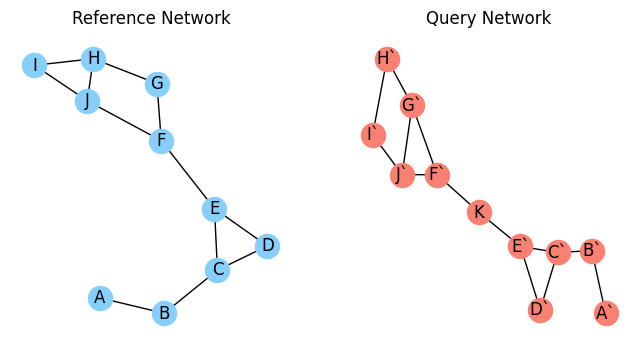

In [1]:
import networkx as nx 
import matplotlib.pyplot as plt 

def load_network(filepath: str) -> nx.Graph:
    G = nx.Graph()
    with open(filepath, 'r') as fp:
        next(fp)
        line = fp.readline().strip()
        while line:
            node, sequence, neighbours = line.split('\t')
            G.add_node(node, sequence=sequence)
            for neighbour in neighbours.split(','):
                G.add_edge(node, neighbour)
            line = fp.readline().strip()
    return G 

def render_networks(R: nx.Graph, Q: nx.Graph) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    pos1 = nx.spring_layout(R, k=0.5)
    pos2 = nx.spring_layout(Q, k=0.5)
    nx.draw(R, pos=pos1, ax=ax[0], with_labels=True, node_size=300, node_color='lightskyblue')
    nx.draw(Q, pos=pos2, ax=ax[1], with_labels=True, node_size=300, node_color='salmon')
    ax[0].set_title('Reference Network')
    ax[1].set_title('Query Network')
    plt.show()

R = load_network('data/ppi1.adjacency') # reference network
Q = load_network('data/ppi2.adjacency') # query network
render_networks(R, Q)


---------------

## Exercises


**Objective Function**

An objective function is required to assess the 'fitness' of a solution. <br>
This is required so that we can migrate towards better solutions over time. 

Today we will provide the objective function, which we need to ***minimise***.<br>
For your interest, our objective function combines two metrics to return a fitness score (referred to as 'energy'):
- *Sequence similarity*, measured by edit distance (i.e. sequence identity with gaps)
- *Toplogical similarity*, measured by edge correctness (i.e. % of edges in the reference network which appear in query network) 


<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

<h3>Exercise 1</h3>
    
<b>Challenge:</b> Write a function which calculates sequence similarity. 

- [ ] Input: the current solution (list of lists), reference graph and query graph.
- [ ] Output: a float number between 0 and 1.

Instructions:
- Iterate through all nodes in reference and query.
- Calculate the edit distance and maximum possible edits.
- Divide the total Levenshtein by the total possible edits.

</div>

In [2]:
import Levenshtein

def sequence_similarity(soln: list, R: nx.Graph, Q: nx.Graph) -> float:
    """
    Calculates sequence similarity using edit distance
    Returned value is a measure of dissimilarity (distance) between 0 and 1.
    Eg a perfect solution returns a value of 0. 
    """
    
    # YOUR CODE HERE
    obs_edits, pos_edits = 0, 0
    for r_node, q_node in soln:
        if r_node is None or q_node is None:
            continue
        else:
            seq1, seq2 = R.nodes[r_node]['sequence'], Q.nodes[q_node]['sequence']
            obs_edits += Levenshtein.distance(seq1, seq2)
            pos_edits += max([len(seq1), len(seq2)])
    sequence_distance = obs_edits / pos_edits
    return sequence_distance

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;"></div>

In [3]:
# Test your function
# Perfect case
soln1 = [
    ['A', 'A`'], ['B', 'B`'], ['C', 'C`'], ['D', 'D`'], ['E', 'E`'],
    ['F', 'F`'], ['G', 'G`'], ['H', 'H`'], ['I', 'I`'], ['J', 'J`'], [None, 'K']
]
seq_dist = sequence_similarity(soln1, R, Q)
print('\nsolution 1 (correct) ---')
print(f'expected=0.00, actual={seq_dist:0.2f}')

# swap two nodes
# neighbour solution
soln2 = [ 
    ['A', 'B`'], ['B', 'A`'], ['C', 'C`'], ['D', 'D`'], ['E', 'E`'],
    ['F', 'F`'], ['G', 'G`'], ['H', 'H`'], ['I', 'I`'], ['J', 'J`'], [None, 'K']
]
seq_dist = sequence_similarity(soln2, R, Q)
print('\nsolution 2 (swapped A and B) ---')
print(f'expected=0.09, actual={seq_dist:0.2f}')

# worst solution
soln3 = [
    ['J', 'K'], ['I', 'A`'], ['H', 'I`'], ['G', 'H`'], ['F', 'G`'],
    ['E', 'F`'], ['D', 'E`'], ['C', 'D`'], ['B', 'C`'], ['A', 'B`'], [None, 'J`'],
]
seq_dist = sequence_similarity(soln3, R, Q)
print('\nsolution 3 (worst) ---')
print(f'expected=0.82, actual={seq_dist:0.2f}')


solution 1 (correct) ---
expected=0.00, actual=0.00

solution 2 (swapped A and B) ---
expected=0.09, actual=0.09

solution 3 (worst) ---
expected=0.82, actual=0.82


<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

<h3>Exercise 2</h3>
    
<b>Challenge:</b> Write a function which calculates topological similarity.

- [ ] Input: the current solution (list of lists), reference graph and query graph.
- [ ] Output: a float number between 0 and 1.

Instructions:
- Iterate through all the edges in the reference graph.
- Map the two nodes on the reference edge to the query graph.
- Check if the edge exists in query graph. (Hint: `Graph_A.has_edge()`)
- Divide the number of matching edges by the total edges on reference.

</div>

In [5]:
def topological_similarity(soln: list, R: nx.Graph, Q: nx.Graph) -> float:
    """
    Calculates topological similarity
    Returned value is a measure of dissimilarity (distance) between 0 and 1.
    Eg a perfect solution returns a value of 0. 
    """

    # YOUR CODE HERE
    # topological similarity (using Edge Correctness, EC)
    graph2_mapper = {r_node: q_node for r_node, q_node in soln if r_node is not None}
    total_edges = len(list(R.edges()))
    mapped_edges = 0
    for r_node1, r_node2 in R.edges():
        q_node1, q_node2 = graph2_mapper[r_node1], graph2_mapper[r_node2]
        if Q.has_edge(q_node1, q_node2):
            mapped_edges += 1
    topological_distance = 1 - (mapped_edges / total_edges)
    return topological_distance

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;"></div>

In [6]:
# Test your function
# Perfect case
soln1 = [
    ['A', 'A`'], ['B', 'B`'], ['C', 'C`'], ['D', 'D`'], ['E', 'E`'],
    ['F', 'F`'], ['G', 'G`'], ['H', 'H`'], ['I', 'I`'], ['J', 'J`'], [None, 'K']
]
top_dist = topological_similarity(soln1, R, Q)
print('\nsolution 1 (correct) ---')
print(f'expected=0.17, actual={top_dist:0.2f}')

# swap two nodes
# neighbour solution
soln2 = [ 
    ['A', 'B`'], ['B', 'A`'], ['C', 'C`'], ['D', 'D`'], ['E', 'E`'],
    ['F', 'F`'], ['G', 'G`'], ['H', 'H`'], ['I', 'I`'], ['J', 'J`'], [None, 'K']
]
top_dist = topological_similarity(soln2, R, Q)
print('\nsolution 2 (swapped A and B) ---')
print(f'expected=0.25, actual={top_dist:0.2f}')

# worst solution
soln3 = [
    ['J', 'K'], ['I', 'A`'], ['H', 'I`'], ['G', 'H`'], ['F', 'G`'],
    ['E', 'F`'], ['D', 'E`'], ['C', 'D`'], ['B', 'C`'], ['A', 'B`'], [None, 'J`'],
]
top_dist = topological_similarity(soln3, R, Q)
print('\nsolution 3 (worst) ---')
print(f'expected=0.50, actual={top_dist:0.2f}')


solution 1 (correct) ---
expected=0.17, actual=0.17

solution 2 (swapped A and B) ---
expected=0.25, actual=0.25

solution 3 (worst) ---
expected=0.50, actual=0.50


In [7]:
# Combining those two similarity functions
def objective_function(soln: list, R: nx.Graph, Q: nx.Graph) -> float:
    sequence_distance = sequence_similarity(soln, R, Q)    
    topological_distance = topological_similarity(soln, R, Q)
    return (sequence_distance + topological_distance) / 2

**Neighbour Solutions**

The cell below displays the fitness of two different solutions. 

We can see that solution 1 (the 'correct' solution) has a lower energy than solution 2. <br>
This property of the objective function is needed so we can perform optimisation. 


In [ ]:
# best solution
soln1 = [
    ['A', 'A`'], ['B', 'B`'], ['C', 'C`'], ['D', 'D`'], ['E', 'E`'],
    ['F', 'F`'], ['G', 'G`'], ['H', 'H`'], ['I', 'I`'], ['J', 'J`'], [None, 'K']
]
energy = objective_function(soln1, R, Q)
print('\nsolution 1 (correct) ---')
print(f'energy={energy:0.2f}')

# neighbour solution
soln2 = [ 
    ['A', 'B`'], ['B', 'A`'], ['C', 'C`'], ['D', 'D`'], ['E', 'E`'],
    ['F', 'F`'], ['G', 'G`'], ['H', 'H`'], ['I', 'I`'], ['J', 'J`'], [None, 'K']
]
print('\nsolution 2 (swapped A and B) ---')
energy = objective_function(soln2, R, Q)
print(f'energy={energy:0.2f}')


These two solutions are quite similar. The only difference is that two node mappings have been swapped. 

```python
current		neighbour
['A', 'A`']	['A', 'B`'] <-
['B', 'B`']	['B', 'A`'] <-
['C', 'C`']	['C', 'C`']
['D', 'D`']	['D', 'D`']
['E', 'E`']	['E', 'E`']
['F', 'F`']	['F', 'F`']
['G', 'G`']	['G', 'G`']
['H', 'H`']	['H', 'H`']
['I', 'I`']	['I', 'I`']
['J', 'J`']	['J', 'J`']
[None, 'K']	[None, 'K']

```

We will use this approach to generate 'neighbour' solutions. <br>
Starting with a current solution, we will pick two node mappings at random, then perform the swap. 


<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

<h3>Exercise 3</h3>
    
<b>Challenge:</b> Write a function which generates a neighbour solution. 

- [ ] Input: the current solution (list of lists).
- [ ] Output: a random neighbouring solution (list of lists).

Instructions:
- Randomly choose two node mappings and swap them. 
- Both the current and neighbour solution should have the same number of elements. 


</div>


In [8]:
import random
from copy import deepcopy

def generate_neighbour(c_solution: list) -> list:
    ### YOUR CODE HERE
    swap1, swap2 = random.sample(range(0, len(c_solution)), 2)
    n_solution = deepcopy(c_solution)
    n_solution[swap1][1], n_solution[swap2][1] = n_solution[swap2][1], n_solution[swap1][1]
    return n_solution

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;"></div>

In [10]:
# TESTS 
# run this cell multiple times. 
# the new solution should be different each time. 
# check visually whether your code works (altered pairs displayed in red). 
c_solution = [
    ['A', 'A`'], ['B', 'B`'], ['C', 'C`'], ['D', 'D`'], ['E', 'E`'], 
    ['F', 'F`'], ['G', 'G`'], ['H', 'H`'], ['I', 'I`'], ['J', 'J`'], [None, 'K']
]
n_solution = generate_neighbour(c_solution)
print('current\t\tneighbour')
for c_pair, n_pair in zip(c_solution, n_solution):
    if c_pair == n_pair:
        print(f'{c_pair}\t{n_pair}')
    else:
        print(f"\x1b[31m{c_pair}\t{n_pair}\x1b[0m")


current		neighbour
['A', 'A`']	['A', 'J`']
['B', 'B`']	['B', 'B`']
['C', 'C`']	['C', 'C`']
['D', 'D`']	['D', 'D`']
['E', 'E`']	['E', 'E`']
['F', 'F`']	['F', 'F`']
['G', 'G`']	['G', 'G`']
['H', 'H`']	['H', 'H`']
['I', 'I`']	['I', 'I`']
['J', 'J`']	['J', 'A`']
[None, 'K']	[None, 'K']


**Acceptance Probabilities**

Once we have generated a new solution, we need to make a decision: whether to jump or stay. <br>
This decision will be represented as a probability. 

There are three things to consider:
1. If the new solution is better (lower energy), we should always accept it. 
2. If the new solution is worse, we should sometimes accept it, so that we don't get stuck in a local optimum. 
3. As we get closer to the end of our run, we should accept worse solutions less often.  

This process (or 'schedule') means we will become greedier over time.<br>
We will define a 'temperature' variable so we can take this into consideration. 

To calculate the acceptance probability we will use the following formula. 

$P(e, e', T)=1$ if $e'<e$, otherwise $\exp(-(e'-e)/T)$


<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

<h3>Exercise 4</h3>
    
<b>Challenge:</b> Write a function which calculates the acceptance probability. 

- [ ] Inputs: 
    - energy of the current solution (float); 
    - energy of the neighbour solution (float); 
    - the current temperature (float); 
- [ ] Output: probability between 0 and 1 (float).


The <small>`math.exp(x)`</small> function can be used to calculate <small>`e`</small> raised to the power <small>`x`</small>.

</div>

In [11]:
import math 

def acceptance(c_energy: float, n_energy: float, temp: float) -> float:
    ### YOUR CODE HERE
    if n_energy < c_energy:
        return 1
    return math.exp(-(n_energy - c_energy) / temp)

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;"></div>

In [12]:
# TESTS 
# a better solution at the start of our run
print(f'expected=1.00, actual={acceptance(c_energy=0.5, n_energy=0.5, temp=1.00):0.2f}')
# a worse solution at the start of our run
print(f'expected=0.82, actual={acceptance(c_energy=0.5, n_energy=0.7, temp=1.00):0.2f}')
# a worse solution in the middle of our run
print(f'expected=0.67, actual={acceptance(c_energy=0.5, n_energy=0.7, temp=0.5):0.2f}')
# a worse solution at the end of our run
print(f'expected=0.00, actual={acceptance(c_energy=0.5, n_energy=0.7, temp=0.001):0.2f}')


expected=1.00, actual=1.00
expected=0.82, actual=0.82
expected=0.67, actual=0.67
expected=0.00, actual=0.00


**Simulated Annealing**

Now that we can generate solutions, assess their fitness (energy), and calculate whether to accept a new solution, we can finally perform simulated annealing. 

<img src="./media/pseudocode.png" width="700"><br>
<small>*Pseudocode from the [Wikipedia article](https://en.wikipedia.org/wiki/Simulated_annealing#Pseudocode) on simulated annealing*</small>

We will specify a parameter k_max, which controls the number of iterations we will perform. <br> 
At the end of our run, we will return the current solution (hopefully, the best one). 


<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

<h3>Exercise 5</h3>
    
<b>Challenge:</b> Write a function which performs simulated annealing to identify the optimal alignment of two networks. 

- [ ] Inputs: 
    - the reference network (nx.Graph); 
    - the query network (nx.Graph); 
    - the maximum number of steps k_max (int); 
- [ ] Output: a tuple containing the final energy and solution

Part of the solution has been implemented. 
You will need to:
1. Generate a neighbour solution
2. Calculate the energy of this neighbour
3. Decide whether to jump using your <small>`acceptance()`</small> function and <small>`random.random()`</small>

Note: The <small>`random.random()`</small> function generates a random value between 0 and 1. 

</div>

In [ ]:
import time 
import random
from typing import Tuple 

def simulated_annealing(R: nx.Graph, Q: nx.Graph, k_max: int=10000) -> Tuple:
    # initialise random starting state and fitness score
    c_energy = 1
    c_solution = [
        ['J', 'K'], ['I', 'A`'], ['H', 'I`'], ['G', 'H`'], ['F', 'G`'],
        ['E', 'F`'], ['D', 'E`'], ['C', 'D`'], ['B', 'C`'], ['A', 'B`'], [None, 'J`'],
    ]

    # iterate
    for k in range(k_max):
        time.sleep(0.0005)
        temp = 1 - (k / k_max)
        print(f'temp={temp:0.2f}, energy={c_energy:0.2f}', end='\r')

        # 1. generate neighbour solution
        # 2. calculate energy of neighbour solution
        # 3. decide whether to jump or stay
        ### YOUR CODE HERE
        raise NotImplementedError


<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;"></div>

In [ ]:
# TESTS
# feel free to change the time.sleep() value in the function above to increase/decrease run speed
energy, solution = simulated_annealing(R, Q)
print(f'\n\nfinal state:')
for r_node, q_node in solution:
    print(f'{r_node} -> {q_node}')


(End of tutorial)